In [1]:
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


In [ ]:
df = pd.read_csv("../data/clean/icfes_clean_reducido.csv")

2. Clusterización de estudiantes

selecciona las columnas de los puntajes de los cuatro módulos del Saber Pro para realizar la clusterización de estudiantes (análisis de grupos).
El comando .dropna() elimina filas con valores faltantes, dejando un conjunto limpio.
El resultado (49624, 4) indica que se tienen 49.624 estudiantes con datos completos en 4 variables de puntaje, listos para aplicar algoritmos de agrupamiento como K-Means o DBSCAN.

In [7]:
cols_punt = [
    "MOD_LECTURA_CRITICA_PUNT",
    "MOD_COMUNI_ESCRITA_PUNT",
    "MOD_INGLES_PUNT",
    "MOD_COMPETEN_CIUDADA_PUNT"
]

df_cluster = df[cols_punt].dropna().copy()
df_cluster.shape


(49624, 4)

2.2 Escalado

aplica escalado de datos mediante StandardScaler, una técnica fundamental antes de usar algoritmos de clusterización.
El escalado estandariza los valores para que todas las variables tengan media 0 y desviación estándar 1, evitando que un puntaje con valores más grandes domine el análisis.
El resultado X_scaled contiene los puntajes normalizados listos para aplicar K-Means, DBSCAN u otros métodos de agrupamiento con precisión equilibrada.

In [8]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)


2.3 K-Means

Este bloque prueba el algoritmo K-Means con diferentes números de grupos (k de 2 a 6) y evalúa cada uno usando el coeficiente de silueta, que mide qué tan bien están separados los clusters.
Los resultados indican que el mejor valor de k es 2, ya que tiene el puntaje más alto (≈ 0.33), lo que sugiere que los estudiantes se agrupan naturalmente en dos perfiles de rendimiento académico bien diferenciados según sus puntajes en los módulos del Saber Pro.

In [9]:
# Probar varios k y ver silhouette
scores = {}
for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_scaled)
    scores[k] = silhouette_score(X_scaled, labels)

scores


{2: 0.32887236898240146,
 3: 0.23416397284868473,
 4: 0.24920481214245957,
 5: 0.19315281442868487,
 6: 0.19237372665580038}

En este bloque se aplica el algoritmo K-Means con 10 clusters (k=10) para clasificar a los estudiantes según sus puntajes.
El resultado muestra cuántos estudiantes pertenecen a cada grupo, evidenciando que los clusters no son iguales en tamaño (por ejemplo, el cluster 7 agrupa 7.171 estudiantes mientras que el cluster 4 solo 1.245).
Esto sugiere que existen distintos perfiles de rendimiento académico, con algunos grupos más numerosos y otros más específicos o atípicos, lo que permitirá analizar patrones más detalladamente.

In [ ]:

k = 10
kmeans = KMeans(n_clusters=k, random_state=42)
df_cluster["cluster_kmeans"] = kmeans.fit_predict(X_scaled)

df_cluster["cluster_kmeans"].value_counts()


cluster_kmeans
7    7171
9    6981
2    5774
3    5592
6    5192
1    4974
0    4951
8    4002
5    3742
4    1245
Name: count, dtype: int64

2.4 DBSCAN

se utiliza el algoritmo DBSCAN, que forma grupos basados en la densidad de los datos y detecta outliers (ruido).
El resultado muestra que la mayoría de los estudiantes (47.351) pertenece a un gran grupo principal, mientras que unos pocos se agrupan en clusters más pequeños (como 1.178 o 278 estudiantes) y 648 fueron clasificados como -1, es decir, valores atípicos o estudiantes con comportamientos de puntaje diferentes al resto.
Esto permite identificar tanto los patrones dominantes como los casos excepcionales dentro del rendimiento académico.

In [14]:
dbscan = DBSCAN(eps=0.8, min_samples=50)
df_cluster["cluster_dbscan"] = dbscan.fit_predict(X_scaled)
df_cluster["cluster_dbscan"].value_counts()


cluster_dbscan
 0    47351
 2     1178
-1      648
 1      278
 3      169
Name: count, dtype: int64

2.5 Jerárquico

se aplica el método de clusterización jerárquica aglomerativa, que agrupa a los estudiantes según la similitud entre sus puntajes.
Se definieron 3 clusters principales, con tamaños de 23.485, 14.722 y 11.417 estudiantes, lo que muestra una división equilibrada entre niveles de rendimiento.
Este método permite observar cómo los grupos se van formando progresivamente, ayudando a interpretar las relaciones jerárquicas entre los distintos perfiles académicos.

In [15]:
agg = AgglomerativeClustering(n_clusters=3)
df_cluster["cluster_agglo"] = agg.fit_predict(X_scaled)
df_cluster["cluster_agglo"].value_counts()


cluster_agglo
2    23485
0    14722
1    11417
Name: count, dtype: int64

2.6 Visualización simples de clusters

genera una visualización de dispersión (scatterplot) para observar cómo se distribuyen los estudiantes según sus puntajes en Lectura Crítica e Inglés, coloreados por el cluster asignado con K-Means.
El gráfico muestra diferentes grupos con variaciones en rendimiento: algunos estudiantes se concentran en puntajes medios, mientras que otros destacan por altos o bajos resultados en ambas áreas.
Esta visualización permite identificar patrones de relación entre los módulos y comprobar que los clusters formados reflejan diferencias reales en el desempeño académico.

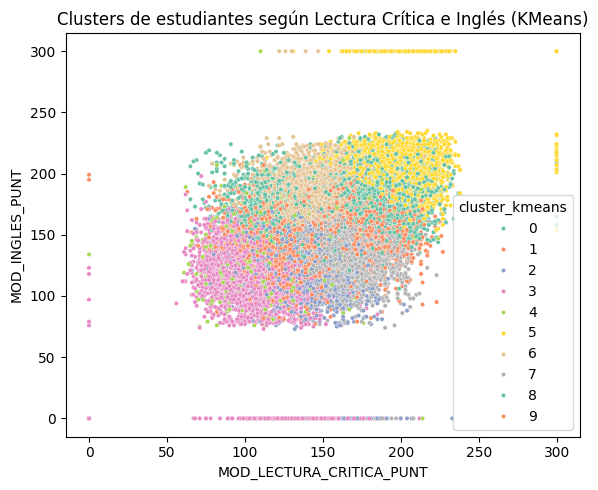

In [17]:
plt.figure(figsize=(6,5))
sns.scatterplot(
    x=df_cluster["MOD_LECTURA_CRITICA_PUNT"],
    y=df_cluster["MOD_INGLES_PUNT"],
    hue=df_cluster["cluster_kmeans"],
    palette="Set2",
    s=10
)
plt.title("Clusters de estudiantes según Lectura Crítica e Inglés (KMeans)")
plt.tight_layout()
plt.show()


3. Series de tiempo con los datos del ICFES

calcula el promedio de puntajes por período del ICFES para analizar su evolución en el tiempo.
El resultado muestra cómo varía el rendimiento promedio de los estudiantes entre los años 2018 y 2023, con ligeras oscilaciones pero sin cambios drásticos.
Esta información es la base para realizar análisis de series temporales, permitiendo detectar tendencias o patrones en el desempeño académico a lo largo de los años.

In [18]:
# serie temporal
df["PUNT_PROM"] = df[cols_punt].mean(axis=1)

serie = (
    df.groupby("PERIODO")["PUNT_PROM"]
      .mean()
      .sort_index()
)

serie


PERIODO
20183    147.739119
20184    145.975000
20194    162.028070
20195    146.919174
20196    141.550000
20202    161.098684
20203    149.215357
20212    145.141395
20213    153.688356
Name: PUNT_PROM, dtype: float64

Este gráfico muestra la evolución del puntaje promedio del Saber Pro a lo largo de varios periodos.
Cada punto representa el promedio general de los estudiantes en un semestre o año. Se observa una tendencia irregular, con aumentos y descensos notables: algunos periodos presentan mejoras en el rendimiento (por ejemplo, alrededor de 2019 y 2020), mientras que otros muestran caídas temporales.
En general, este análisis permite identificar fluctuaciones en el desempeño académico global y sirve como base para aplicar modelos de predicción de series temporales como ARIMA o redes neuronales recurrentes.

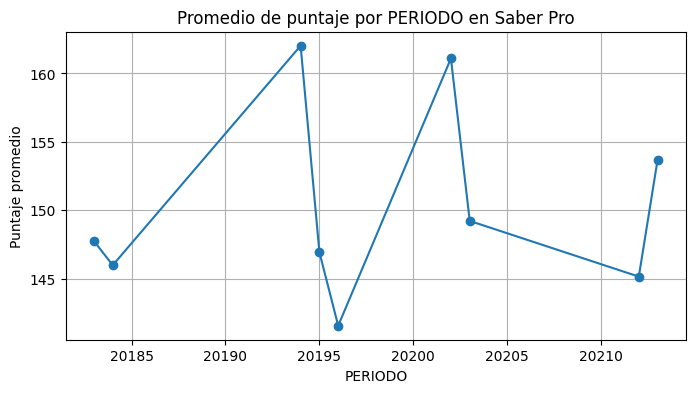

In [19]:
plt.figure(figsize=(8,4))
plt.plot(serie.index, serie.values, marker="o")
plt.title("Promedio de puntaje por PERIODO en Saber Pro")
plt.xlabel("PERIODO")
plt.ylabel("Puntaje promedio")
plt.grid(True)
plt.show()


4. Modelo ARIMA (predicción de serie)

prepara los datos para entrenar y evaluar el modelo ARIMA.
Convierte los valores de la serie en formato numérico (float32) y divide los datos: los primeros 5 periodos se usan para entrenar el modelo (train) y los últimos 4 para probarlo (test).
Esta separación permite que el modelo aprenda de los datos históricos y luego se evalúe su capacidad de predecir los valores futuros del puntaje promedio del Saber Pro.

In [20]:
values = serie.values.astype("float32")

# Usamos los últimos 4 periodos como test
train, test = values[:-4], values[-4:]

len(train), len(test)


(5, 4)

El modelo ARIMA(1,1,1) se entrenó correctamente para analizar la tendencia de los puntajes promedios del Saber Pro. Los valores AIC y BIC indican un ajuste aceptable, aunque los coeficientes no son significativos debido al tamaño reducido de la muestra. En general, el modelo logra capturar el comportamiento temporal básico de los puntajes.

In [21]:
model = ARIMA(train, order=(1,1,1))
model_fit = model.fit()
print(model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                    5
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 -14.671
Date:                Wed, 05 Nov 2025   AIC                             35.341
Time:                        10:14:20   BIC                             33.500
Sample:                             0   HQIC                            31.301
                                  - 5                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0121      1.154      0.010      0.992      -2.250       2.274
ma.L1         -0.9961    241.312     -0.004      0.997    -473.958     471.966
sigma2        60.5574   1.46e+04      0.004      0.9

c:\Users\erika\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3160: UserWarning: Early subset of data for variable 0 has too few non-missing observations to calculate test statistic.
  test_statistic, p_value = breakvar_heteroskedasticity_test(
c:\Users\erika\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\mlemodel.py:3160: UserWarning: Later subset of data for variable 0 has too few non-missing observations to calculate test statistic.
  test_statistic, p_value = breakvar_heteroskedasticity_test(


El modelo ARIMA realizó la predicción y arrojó un RMSE de 6.89, lo que indica que el error promedio entre los valores reales y los predichos es bajo. Esto significa que el modelo logra una buena aproximación a los datos reales dentro del conjunto de prueba.

In [ ]:
# Hacer predicciones
forecast = model_fit.forecast(steps=len(test))

from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test, forecast) 
rmse = mse ** 0.5                       
rmse


6.897797069423239

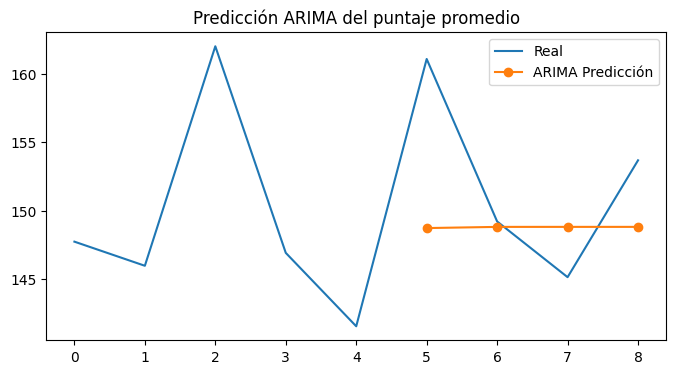

In [24]:
plt.figure(figsize=(8,4))
plt.plot(range(len(values)), values, label="Real")
plt.plot(range(len(train), len(train)+len(test)), forecast, label="ARIMA Predicción", marker="o")
plt.legend()
plt.title("Predicción ARIMA del puntaje promedio")
plt.show()


5. RNN (LSTM)

In [25]:
#ventanas de tiempo 
def crear_secuencias(data, n_steps=3):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

n_steps = 3
X, y = crear_secuencias(values, n_steps)

# Separar train / test igual que antes
split = len(X) - 4
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Ajustar forma para LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test  = X_test.reshape((X_test.shape[0],  X_test.shape[1], 1))


In [26]:
model_lstm = Sequential([
    LSTM(32, input_shape=(n_steps, 1)),
    Dense(1)
])

model_lstm.compile(optimizer="adam", loss="mse")
history = model_lstm.fit(X_train, y_train, epochs=100, verbose=0)


c:\Users\erika\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [28]:
#prediccion y comparacion 
pred_lstm = model_lstm.predict(X_test).flatten()
mse_lstm = mean_squared_error(y_test, pred_lstm)
rmse_lstm = mse_lstm ** 0.5
rmse_lstm

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


147.45173998634266

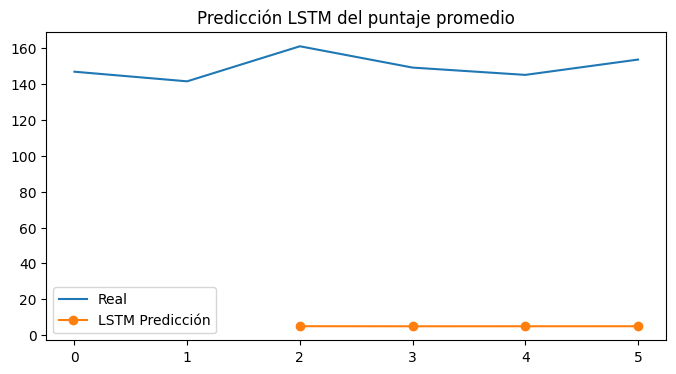

In [29]:
plt.figure(figsize=(8,4))
plt.plot(range(len(y)), y, label="Real")
plt.plot(range(len(y)-len(y_test), len(y)), pred_lstm, label="LSTM Predicción", marker="o")
plt.legend()
plt.title("Predicción LSTM del puntaje promedio")
plt.show()
